# 3.2 线性回归的从零开始实现

In [14]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.10.0


## 3.2.1 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [16]:
for i in range(num_examples):
    print(features[i], labels[i])

tensor([0.3456, 0.5420]) tensor(3.0416)
tensor([0.1050, 0.9081]) tensor(1.3033)
tensor([0.5455, 0.2661]) tensor(4.3778)
tensor([ 0.9379, -1.0438]) tensor(9.6315)
tensor([-0.5734, -0.6833]) tensor(5.3793)
tensor([1.5284, 1.0823]) tensor(3.5640)
tensor([-0.2800,  0.7612]) tensor(1.0565)
tensor([-0.4862, -0.4028]) tensor(4.5959)
tensor([-1.8052,  1.7221]) tensor(-5.2428)
tensor([ 1.2230, -1.0783]) tensor(10.2893)
tensor([-0.9787, -0.6419]) tensor(4.4268)
tensor([-1.1796,  0.2000]) tensor(1.1533)
tensor([ 0.0109, -1.5791]) tensor(9.5898)
tensor([0.8153, 0.3307]) tensor(4.7016)
tensor([ 0.5761, -2.0225]) tensor(12.2330)
tensor([-0.7117, -0.9897]) tensor(6.1473)
tensor([0.6816, 0.2043]) tensor(4.8630)
tensor([0.0476, 0.7702]) tensor(1.6703)
tensor([-0.2139, -0.1520]) tensor(4.2940)
tensor([-0.2417,  0.3337]) tensor(2.5740)
tensor([-1.3405, -1.0673]) tensor(5.1469)
tensor([-0.4914,  0.6405]) tensor(1.0270)
tensor([-0.0509,  0.8531]) tensor(1.1932)
tensor([ 0.7263, -1.6148]) tensor(11.1506)
te

/tmp/ipykernel_3681199/245910263.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


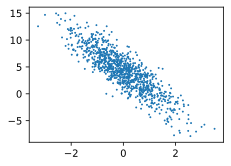

In [18]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3714,  1.1033],
        [ 0.3622, -0.5012],
        [ 0.0584, -1.0711],
        [ 1.6266,  1.1201],
        [-0.2942,  1.0741],
        [ 1.6380, -0.4905],
        [-1.0441, -0.0034],
        [ 0.4600, -0.7443],
        [ 0.5884,  0.0359],
        [-1.2956, -0.1050]]) 
 tensor([-0.2959,  6.6200,  7.9578,  3.6301, -0.0358,  9.1465,  2.1412,  7.6573,
         5.2542,  1.9588])


## 3.2.3 初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [9]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [10]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [11]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [20]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050
epoch 6, loss 0.000050
epoch 7, loss 0.000050
epoch 8, loss 0.000049
epoch 9, loss 0.000050
epoch 10, loss 0.000049


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.4003]], requires_grad=True)
4.2 
 tensor([4.2001], requires_grad=True)
